In [2]:
""" Load Relevant Packages """ 

import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning')

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
from typing import Union
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


In [255]:
"""
Download data created in Pyhton
"""

# create a numpy array
nparray = df_most_div_port_weights_daily

# Saving the array
np.savetxt("df_most_div_port_weights_daily.csv", nparray, delimiter=",")

# Reading the csv into an array
firstarray = np.genfromtxt("df_most_div_port_weights_daily.csv", delimiter=",")

In [3]:
"""
Load Data
"""

ret = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/merged_short.xlsx')
returns = ret.set_index('date')

# calculate start and end dates from index
start_date = returns.index.min()
end_date = returns.index.max()

In [4]:
# colors for factors

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Define inputs for calculations

In [5]:
"""
Define inputs
"""

# number of periods
num_periods = len(ret)

# number of factors
num_assets = len(returns.columns)

# window size 
window_size = 252 # 1 year of daily observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = window_size/2

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities for decaying covariance matrix
def calculate_exponential_decay_probabilities(target_time_point: Union[int, float], time_points: np.ndarray,
                                              half_life: Union[float, int]) -> np.ndarray:
    """
    Calculates exponential decay probabilities for an array of time points based on a target time point and a half life.
    Parameters
    ----------
    target_time_point:
        The target time point.
    time points:
        The array of time points to calculate probabilities for.
    half_life:
        The half life of the exponential decay.
    Returns
    -------
    Exponential decay probabilities.
    """
    
    numerator = np.exp(-np.log(2) / half_life * np.clip(target_time_point - time_points, 0, np.inf))
    denominator = np.sum(numerator)

    p_t = numerator / denominator

    return p_t

exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
weights_eq = np.array(w_eq).astype(float)

# Calculate Risk Contributions for Equally Weighted Portfolio

In [6]:
def calculate_decaying_cov_mat(x: np.ndarray, probs: np.ndarray, axis: int = 0) -> np.ndarray:

    """
    Estimates a covariance matrix based on a historical dataset and a set of probabilities.
    Parameters
    ----------
    x:
        The dataset to estimate covariance for.
    probs:
        The probabilities to weight the observations of the dataset by.
    axis:
        The axis to estimate over.
    Returns
    -------
    np.ndarray
        The estimated covariance matrix.
    """

    x = x.T if axis == 1 else x

    expected_x_squared = np.sum(probs[:, None, None] * np.einsum('ji, jk -> jik', x, x), axis=0)
    mu = probs @ x
    mu_squared = np.einsum('j, i -> ji', mu, mu)
    cov_mat = expected_x_squared - mu_squared

    return cov_mat

In [7]:
def calculate_simple_cov_mat(x: np.ndarray, axis: int = 0) -> np.ndarray:
    
    x = x.T if axis == 1 else x
    
    cov_mat = np.cov(x, rowvar=False)
    
    return cov_mat

In [8]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
    """
    Function that calculates marginal risk using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    inner_derivative = cov_mat @ weights

    return inner_derivative / total_risk


def calculate_risk_contributions_std(weights: np.ndarray, cov_mat: np.ndarray, scale: bool = False) -> np.ndarray:
    """
    Function that calculates risk contributions using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    scale:
        Scale risk contribution.
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_std(weights, cov_mat)
    mrc = weights * mr

    if scale:
        mrc /= np.sum(mrc)

    return mrc

In [9]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_decaying_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

(0.0, 1.0)

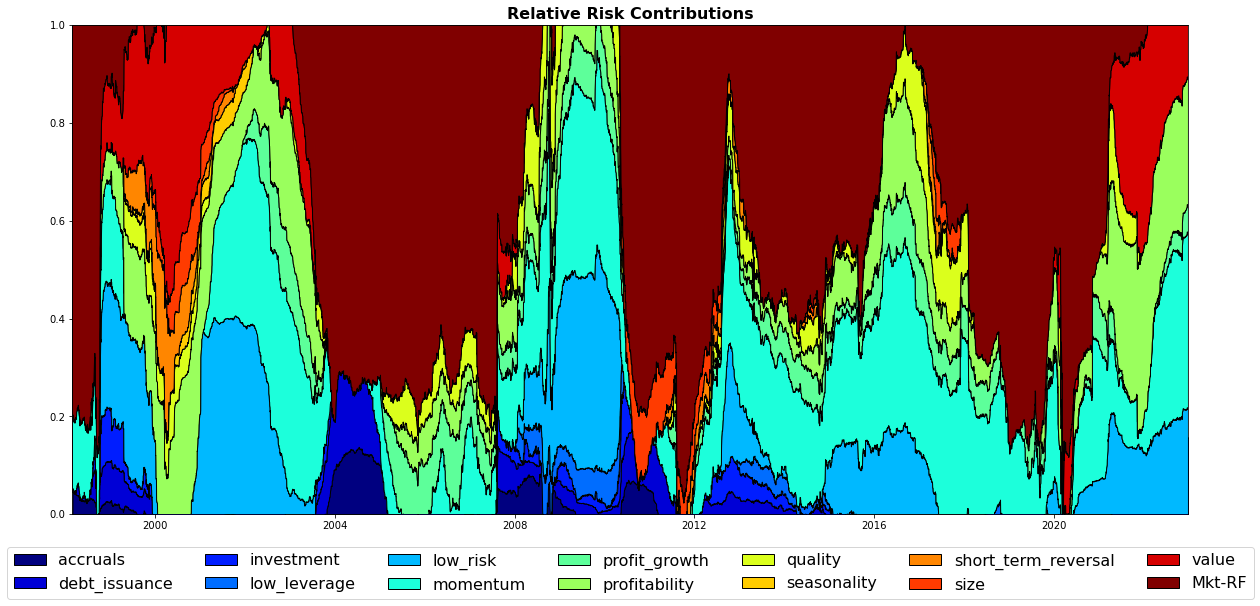

In [10]:
"""
Plot Risk contributions
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              rel_risk_contribs.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_title("Relative Risk Contributions", fontsize=16, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Calculate Diversification Ratio

In [11]:
"""
Define function for portfolio std and var
"""

def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights


def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))


def cov_to_corr_matrix(cov_mat):
    
    vols = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1 # numerical error 
    
    return corr_mat

In [12]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""

def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = calculate_portfolio_std(weights=weights, cov_mat=cov_mat)
    
    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [13]:
cc_ratios = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_decaying_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios[t] = calculate_cc_ratio(w_eq, cov_mat)

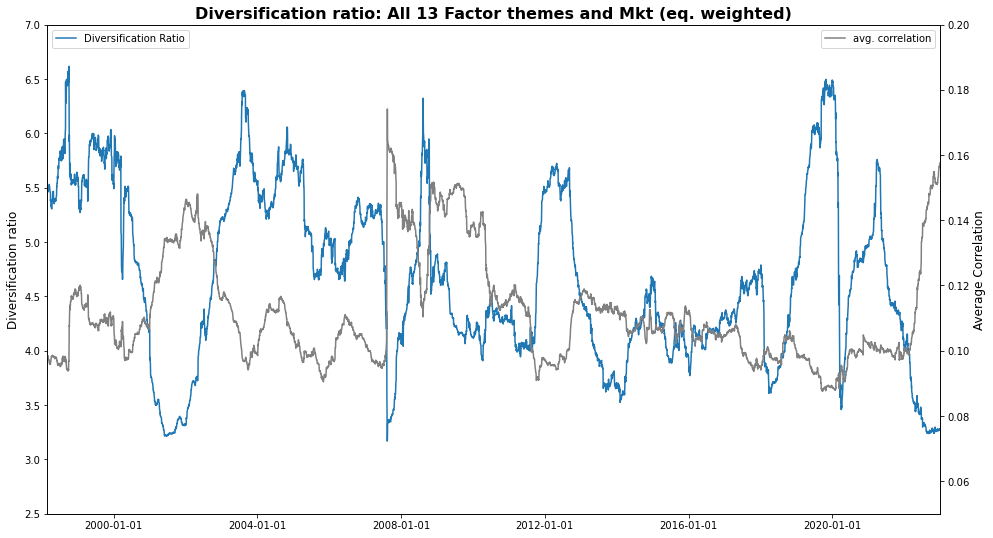

In [14]:
"""
Plot Diversification Ratio and Average Correlation
"""

fig, ax = plt.subplots(figsize=(16, 9))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.plot(returns.index[window_size:], cc_ratios, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio", fontsize=12)
ax.set_title("Diversification ratio: All 13 Factor themes and Mkt (eq. weighted)", fontsize=16, fontweight='bold');
ax.legend(loc='upper left')
ax_new = ax.twinx()
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.set_ylim(2.5,7)
ax_new.set_ylim(0.05,0.2)
ax_new.set_ylabel("Average Correlation", fontsize=12)
ax_new.plot(returns.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')

# Most Diversified Portfolio

In [15]:
"""
Define function for long only portfolio
"""

def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [254]:
""" 
Perform calculations for MDP with daily rebalancing
"""

most_div_port_weights_daily = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_daily = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_decaying_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # most diversified
    most_div_port_weights_daily[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc_daily[t] = calculate_cc_ratio(most_div_port_weights_daily[t, :], cov_mat)

# store in data-frame
df_most_div_port_weights_daily = pd.DataFrame(data=most_div_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [16]:
"""
Perform calculations for MDP with monthly rebalancing
"""

most_div_port_weights_monthly = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_monthly = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        # calculate returns for the past 21 periods (month)
        returns_subset = returns.iloc[t: window_size + t, :]
        # covariance matrix
        cov_mat = calculate_decaying_cov_mat(returns_subset.values, probs=exp_probs)
        # most diversified portfolio
        most_div_port_weights_monthly[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly[t] = calculate_cc_ratio(most_div_port_weights_monthly[t, :], cov_mat)
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly[t, :] = most_div_port_weights_monthly[t-1, :]
        most_div_port_cc_monthly[t] = most_div_port_cc_monthly[t-1]

# store in data-frame
df_most_div_port_weights_monthly = pd.DataFrame(data=most_div_port_weights_monthly,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


(0.0, 1.0)

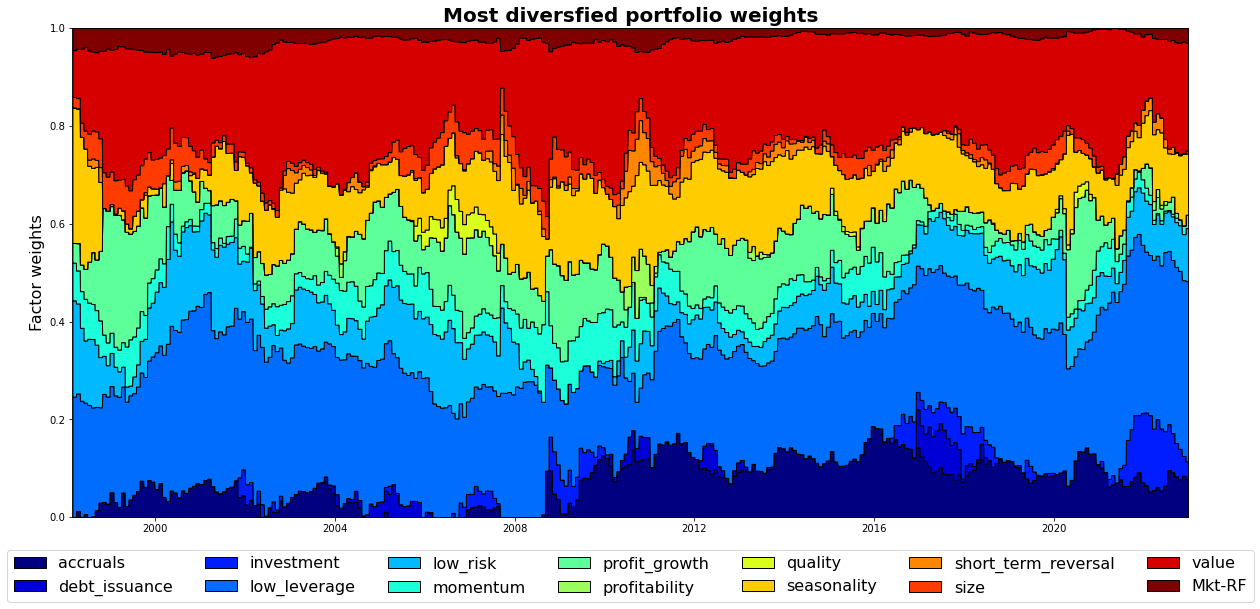

In [17]:
"""
Plot MDP Weights Monthly Rebalancing
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              most_div_port_weights_monthly.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=16)
ax.set_title("Most diversfied portfolio weights",fontsize=20, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Minimum Variance Portfolio

In [18]:
""" 
Define function for minimum variance portfolio 
"""

def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [29]:
""" 
Perform calculations for min_var with daily rebalancing 
"""

min_var_port_weights_daily = np.zeros((eff_num_periods, num_assets))
min_var_port_cc_daily = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_decaying_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # mnimum variance
    min_var_port_weights_daily[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc_daily[t] = calculate_cc_ratio(min_var_port_weights_daily[t, :], cov_mat)
    
# store in data-frame
df_min_var_port_weights_daily = pd.DataFrame(data=min_var_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [19]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing 
"""

min_var_port_weights_monthly = np.zeros((eff_num_periods, num_assets))
min_var_port_cc_monthly = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        # calculate returns for the past 21 periods (month)
        returns_subset = returns.iloc[t: window_size + t, :]
        # covariance matrix
        cov_mat = calculate_decaying_cov_mat(returns_subset.values, probs=exp_probs)
        # most diversified portfolio
        min_var_port_weights_monthly[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly[t] = calculate_cc_ratio(min_var_port_weights_monthly[t, :], cov_mat)
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly[t, :] = min_var_port_weights_monthly[t-1, :]
        min_var_port_cc_monthly[t] = min_var_port_cc_monthly[t-1]

# store in data-frame
df_min_var_port_weights_monthly = pd.DataFrame(data=min_var_port_weights_monthly,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


(0.0, 1.0)

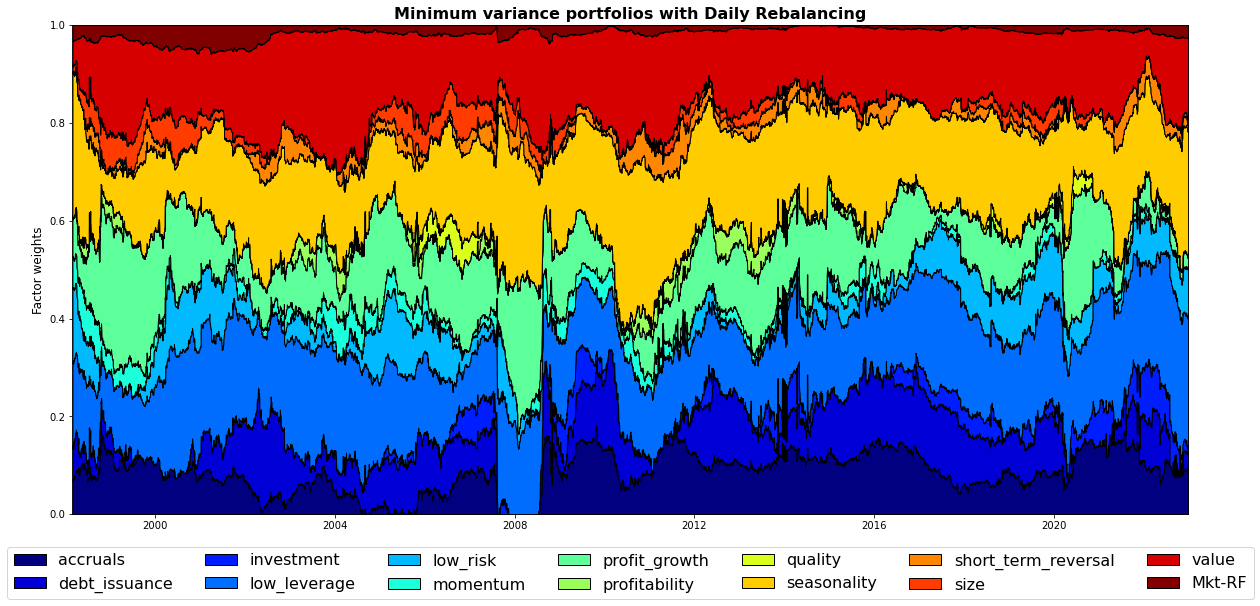

In [31]:
""" 
Plot Minimum Variance Weights with daily rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_daily.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=12)
ax.set_title("Minimum variance portfolios with Daily Rebalancing", fontsize=16, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

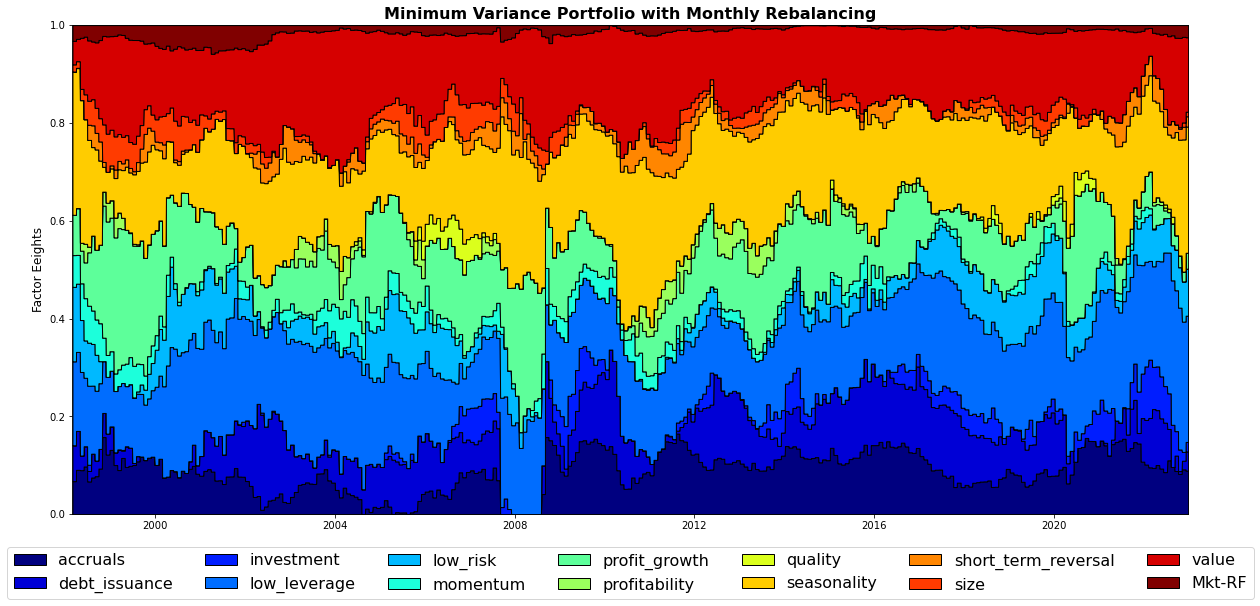

In [21]:
""" 
Plot Minimum Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_monthly.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Eeights', fontsize=12)
ax.set_title("Minimum Variance Portfolio with Monthly Rebalancing", fontsize=16, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');

# Diversifaction Ratio For All Portfolios

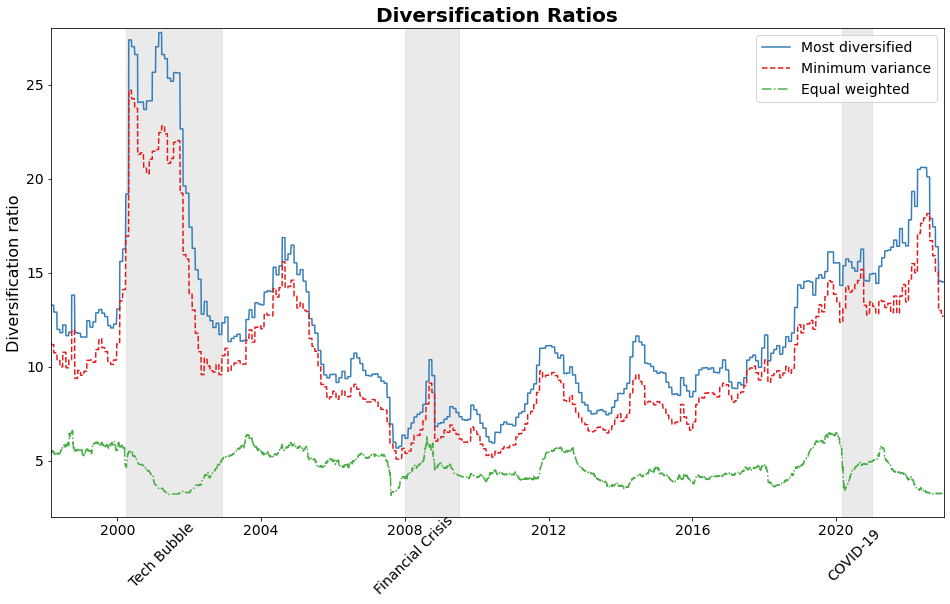

In [28]:
"""
Plot the Diversification Ratios
"""

# Define colors
most_div_color = "#377eb8"
min_var_color = "#e41a1c"
cc_color = "#4daf4a"
gray_color = "#cccccc"

# Define line styles
most_div_linestyle = "-"
min_var_linestyle = "--"
cc_linestyle = "-."

# Plotting Diversification Ratios
fig, ax = plt.subplots(figsize=(16, 9))

# Plot diversification ratios
ax.plot(returns.index[window_size:], most_div_port_cc_monthly, label="Most diversified", color=most_div_color, linestyle=most_div_linestyle)
ax.plot(returns.index[window_size:], min_var_port_cc_monthly, label="Minimum variance", color=min_var_color, linestyle=min_var_linestyle)
ax.plot(returns.index[window_size:], cc_ratios, label="Equal weighted", color=cc_color, linestyle=cc_linestyle)

# Set y-axis label and title
ax.set_ylabel("Diversification ratio", fontsize=16)
ax.set_title("Diversification Ratios", fontweight="bold", fontsize=20)

# Set y-axis limits
ax.set_ylim(2, 28)

# Add legend
ax.legend(fontsize=14)

# Fill empty spaces
ax.set_xlim(returns.index[window_size], returns.index[-1])

# Define recession periods
tech_bubble_start = pd.to_datetime("2000-03-31")
tech_bubble_end = pd.to_datetime("2002-11-30")
financial_crisis_start = pd.to_datetime("2007-12-31")
financial_crisis_end = pd.to_datetime("2009-06-30")
covid_start = pd.to_datetime("2020-02-29")
covid_end = pd.to_datetime("2020-12-31")

# Add vertical shaded regions for recession periods
ax.axvspan(tech_bubble_start, tech_bubble_end, alpha=0.4, color=gray_color)
ax.axvspan(financial_crisis_start, financial_crisis_end, alpha=0.4, color=gray_color)
ax.axvspan(covid_start, covid_end, alpha=0.4, color=gray_color)

# Add text labels for recession periods
ax.text(pd.to_datetime("2001-03-31"), 0, "Tech Bubble", ha="center", va="center", rotation=45, fontsize=14)
ax.text(pd.to_datetime("2008-03-31"), 0, "Financial Crisis", ha="center", va="center", rotation=45, fontsize=14)
ax.text(pd.to_datetime("2020-06-30"), 0, "COVID-19", ha="center", va="center", rotation=45, fontsize=14)

# Set font size of ticks
ax.tick_params(labelsize=14)


# Evaluating Strategies

In [23]:
df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# monthly return
df_port_ret['min-var'] = (returns[window_size:] * df_min_var_port_weights_monthly).sum(axis=1)
df_port_ret['most-div'] = (returns[window_size:] * df_most_div_port_weights_monthly).sum(axis=1)
df_port_ret['eq-weight'] = (returns[window_size:] @ w_eq)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)
df_port_tri

,min-var,most-div,eq-weight
date,,,
1998-02-26,0.999770,0.999741,0.999730
1998-02-27,0.999403,0.999428,0.999221
1998-03-02,0.999398,0.999113,0.998981
1998-03-03,0.999452,0.998919,0.999474
1998-03-04,0.999091,0.998348,0.998872
...,...,...,...
2022-12-23,1.429003,1.437841,1.901132
2022-12-27,1.429201,1.437728,1.905436
2022-12-28,1.428463,1.437371,1.902701


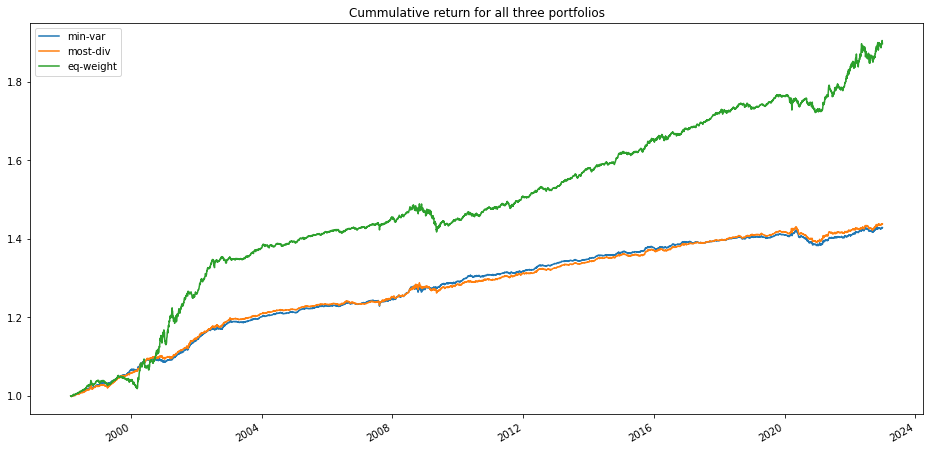

In [34]:
df_port_tri.plot(xlabel="", figsize=(16, 8), title="Cummulative return for all three portfolios");

In [25]:
mean_return = df_port_ret.mean(axis=0)
mean_return

min-var      0.000057
most-div     0.000058
eq-weight    0.000103
dtype: float64

In [26]:
std_return = df_port_ret.std(axis=0)
std_return

min-var      0.000507
most-div     0.000545
eq-weight    0.001254
dtype: float64

In [27]:
ir_ratio = mean_return / std_return
ir_ratio

min-var      0.112692
most-div     0.106787
eq-weight    0.082309
dtype: float64

# Most Diversified Portfolio In-Sample and Out-of-Sample Testing

In [40]:
"""
Most_ Div In-sample and out-of-sample
"""

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_returns, test_returns = train_test_split(returns, test_size=0.2, shuffle=False)

# Calculate the number of periods in the training set
train_num_periods = len(train_returns) - window_size

most_div_port_weights = np.zeros((train_num_periods, num_assets))
most_div_port_cc = np.zeros(train_num_periods)

for t in range(train_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        # calculate returns for the past 21 periods (month)
        returns_subset = train_returns.iloc[t: window_size + t, :]
        # covariance matrix
        cov_mat = calculate_decaying_cov_mat(returns_subset.values, probs=exp_probs)
        # most diversified portfolio
        most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights_monthly[t, :], cov_mat)
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights[t, :] = most_div_port_weights[t-1, :]
        most_div_port_cc[t] = most_div_port_cc[t-1]

# store in data-frame
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=train_returns[window_size:].index,
                                        columns=returns.columns)

# Calculate the number of periods in the testing set
test_num_periods = len(test_returns) - window_size

most_div_port_weights_test = np.zeros((test_num_periods, num_assets))
most_div_port_cc_test = np.zeros(test_num_periods)

for t in range(test_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        # calculate returns for the past 21 periods (month)
        returns_subset = test_returns.iloc[t: window_size + t, :]
        # covariance matrix
        cov_mat = calculate_decaying_cov_mat(returns_subset.values, probs=exp_probs)
        # most diversified portfolio
        most_div_port_weights_test[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_test[t] = calculate_cc_ratio(most_div_port_weights_test[t, :], cov_mat)
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_test[t, :] = most_div_port_weights_test[t-1, :]
        most_div_port_cc_test[t] = most_div_port_cc_test[t-1]

# store in data-frame
df_most_div_port_weights_test = pd.DataFrame(data=most_div_port_weights_test,
                                        index=test_returns[window_size:].index,
                                        columns=returns.columns)


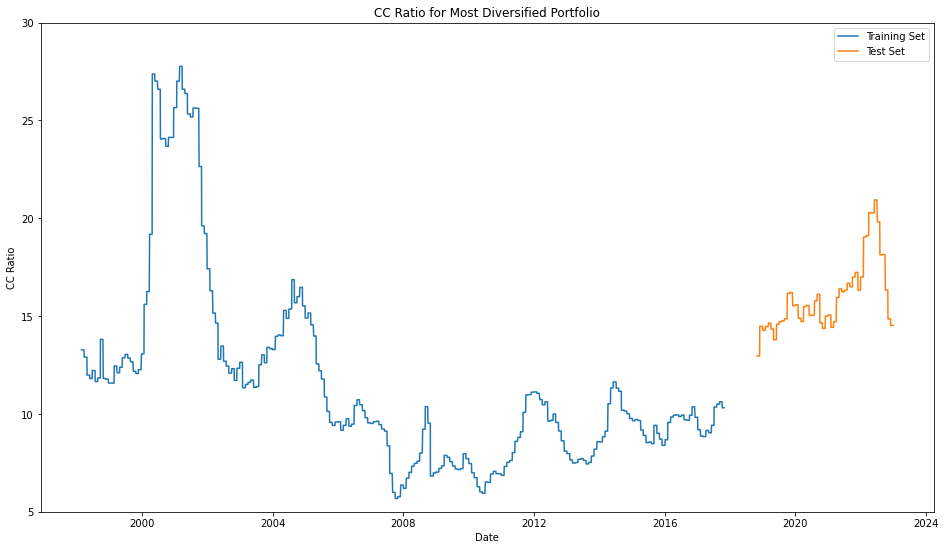

In [41]:
"""
Plot the CC ratios for the training and test set
"""

fig, ax = plt.subplots(figsize=(16, 9))

# plot the CC ratio for the training set
ax.plot(df_most_div_port_weights.index, most_div_port_cc, label='Training Set')

# plot the CC ratio for the test set
ax.plot(df_most_div_port_weights_test.index, most_div_port_cc_test, label='Test Set')

# add title and axis labels
ax.set_title('CC Ratio for Most Diversified Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('CC Ratio')
ax.set_ylim(5,30)

# add legend
plt.legend()

# show the plot
plt.show()

# Tests

In [32]:
# Set in-sample and out-of-sample periods
in_sample_start_date = '1998-05-22'
in_sample_end_date = '2014-12-31'
out_of_sample_start_date = '2015-01-01'
out_of_sample_end_date = '2022-12-31'

# Get in-sample and out-of-sample periods
in_sample_returns = returns[in_sample_start_date:in_sample_end_date]
out_of_sample_returns = returns[out_of_sample_start_date:out_of_sample_end_date]

# Set the number of periods for in-sample testing
in_sample_num_periods = len(in_sample_returns) - window_size + 1

# Set the number of periods for out-of-sample testing
out_of_sample_num_periods = len(out_of_sample_returns) - window_size + 1

# Initialize arrays for in-sample and out-of-sample weights and CC ratios
most_div_port_weights_in = np.zeros((in_sample_num_periods, num_assets))
most_div_port_cc_in = np.zeros(in_sample_num_periods)
most_div_port_weights_out = np.zeros((out_of_sample_num_periods, num_assets))
most_div_port_cc_out = np.zeros(out_of_sample_num_periods)

# Loop through in-sample periods
for t in range(in_sample_num_periods):
    # Covariance matrix
    cov_mat = calculate_decaying_cov_mat(in_sample_returns.iloc[t : window_size + t, :].values, probs=exp_probs)

    # Most diversified portfolio
    most_div_port_weights_in[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc_in[t] = calculate_cc_ratio(most_div_port_weights_in[t, :], cov_mat)

# Loop through out-of-sample periods
for t in range(out_of_sample_num_periods):
    # Covariance matrix
    cov_mat = calculate_decaying_cov_mat(out_of_sample_returns.iloc[t : window_size + t, :].values, probs=exp_probs)

    # Most diversified portfolio
    most_div_port_weights_out[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc_out[t] = calculate_cc_ratio(most_div_port_weights_out[t, :], cov_mat)


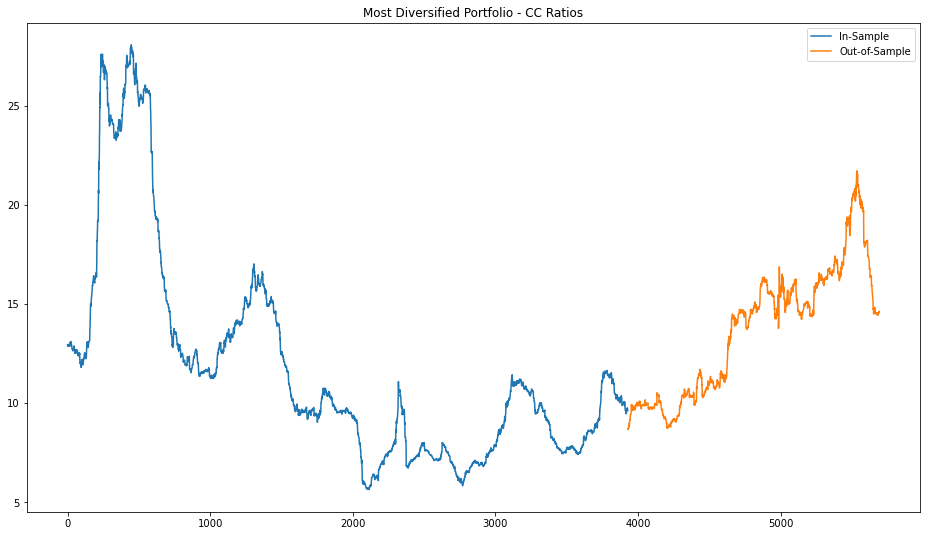

In [33]:
# Plot in-sample and out-of-sample CC ratios
fig = plt.figure(figsize=(16, 9))
plt.plot(most_div_port_cc_in, label='In-Sample')
plt.plot(np.arange(in_sample_num_periods, in_sample_num_periods+out_of_sample_num_periods), most_div_port_cc_out, label='Out-of-Sample')
plt.legend()
plt.title('Most Diversified Portfolio - CC Ratios')
plt.show()
